In [25]:
import matplotlib.pyplot as plt

from pathlib import Path
from lmfit import Parameters
from lmfit import minimize, fit_report

In [2]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [3]:
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3, finishing_pass_design_4
from utilities import *

In [27]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

root_dir = Path.cwd()
result_dir = root_dir / "res"

In [5]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_moreales(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius

In [6]:
in_profile = create_in_profile_for_finishing_train(950 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [7]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd4 = finishing_pass_design_4(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [8]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)
rolling_train_rpd4.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '24-V' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1394.4002427541218),
    cross_section=Polygon(
        area=5.825690658144663e-05,
        height=0.008700000000000006,
        perimeter=0.027128161559818183,
        width=0.00824707465748203,
        ),
    length=92.58526074510861,
    material=['BST500', 'steel'],
    ring_temperatures=array([1394.40024275, 1391.92170778, 1384.48282975, 1372.05601708,
           1354.54958037, 1331.83589524, 1304.03474617, 1272.24837702,
           1239.59659881, 1211.62081219, 1194.4118064 ]),
    strain=np.float64(0.4288888105828533),
    surface_temperature=np.float64(1194.4118064037127),
    t=np.float64(1.8194044577718795),
    temperature=np.float64(1270.289537167055),
    weight=2400,
    width=np.float64(0.00824707465748203),
    )

In [9]:
sequences = [
    {
        "label": "RPD1",
        "sequence": rolling_train_rpd1
    },
    {
        "label": "RPD2",
        "sequence": rolling_train_rpd2
    },
    {
        "label": "RPD3",
        "sequence": rolling_train_rpd3
    },
    # {
    #     "label": "RPD4",
    #     "sequence": rolling_train_rpd4
    # }
]

In [10]:
def solve_total_wear_depths_as_contour_line(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:

            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_4_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["17-H", "18-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_6_pass_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["21-H", "22-V", "23-H", "24-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)


def solve_total_wear_depths_as_contour_line_csb_block(params):
    area_errors = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label and label in ["27-H", "28-V"]:

                        wear_coefficient = get_wear_coefficient(roll_pass, params)
                        calculated_wear_contour = calculate_wear_contour(roll_pass, wear_coefficient, tonnage * 1000)
                        area_error = calculate_area_between_contours(calculated_wear_contour, measured_wear_contour)
                        area_errors.append(area_error)
                    else:
                        continue
    rms_error = root_mean_square_value(np.array(area_errors))
    return np.array(area_errors)

In [11]:
params_constant_cobyla = Parameters()
params_constant_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_4_pass_block_cobyla = Parameters()
params_4_pass_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_6_pass_block_cobyla = Parameters()
params_6_pass_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_csb_block_cobyla = Parameters()
params_csb_block_cobyla.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

In [ ]:
result_constant_cobyla = minimize(
    solve_total_wear_depths_as_contour_line,
    params_constant_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [ ]:
result_4_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_4_pass_block,
    params_4_pass_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [ ]:
result_6_pass_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_6_pass_block,
    params_6_pass_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [ ]:
result_csb_block_cobyla = minimize(
    solve_total_wear_depths_as_contour_line_csb_block,
    params_csb_block_cobyla,
    nan_policy='omit',
    max_nfev=100,
    method="cobyla"
)

In [16]:
print(fit_report(result_csb_block_cobyla))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 19
    # data points      = 16
    # variables        = 1
    chi-square         = 1.2682e-09
    reduced chi-square = 8.4546e-11
    Akaike info crit   = -370.132176
    Bayesian info crit = -369.359588
[[Variables]]
    wear_coefficient:  8.1723e-10 +/- 1.4021e-10 (17.16%) (init = 1e-05)


In [18]:
measured_wear_area = []
calculated_wear_area = []

measured_wear_area_4_pass = []
calculated_wear_area_4_pass = []

measured_wear_area_6_pass = []
calculated_wear_area_6_pass = []

measured_wear_area_csb = []
calculated_wear_area_csb = []

for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    measured_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                    calculated_wear_area.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                    if roll_pass.label in ["17-H", "18-V"]:
                        calculated_wear_contour = calculate_wear_contour(roll_pass, result_4_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                        calculated_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["21-H", "22-V", "23-H", "24-V"]:
                         calculated_wear_contour = calculate_wear_contour(roll_pass, result_6_pass_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                         calculated_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))

                    elif roll_pass.label in ["27-H", "28-V"]:
                         calculated_wear_contour = calculate_wear_contour(roll_pass, result_csb_block_cobyla.params['wear_coefficient'].value, tonnage * 1000)
                         calculated_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))


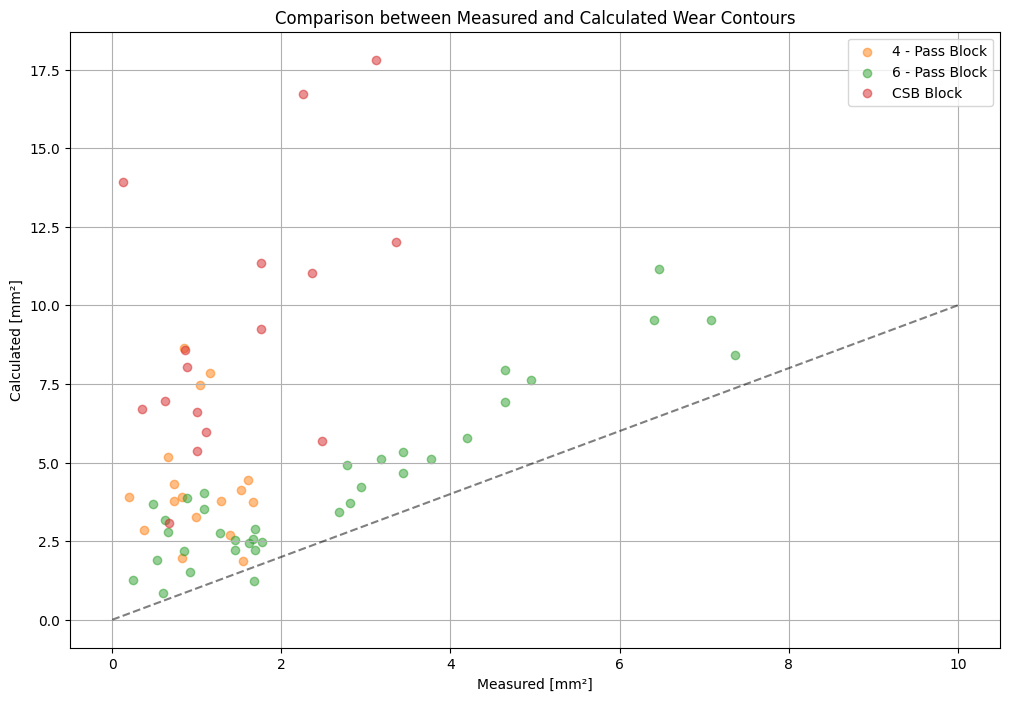

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours")
ax.scatter(np.array(measured_wear_area_4_pass) * 1e6, np.array(calculated_wear_area_4_pass) * 1e6, color='C1', alpha=0.5, label="4 - Pass Block")
ax.scatter(np.array(measured_wear_area_6_pass) * 1e6, np.array(calculated_wear_area_6_pass) * 1e6, color='C2', alpha=0.5, label="6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_per_block.pdf", bbox_inches='tight', dpi=300)

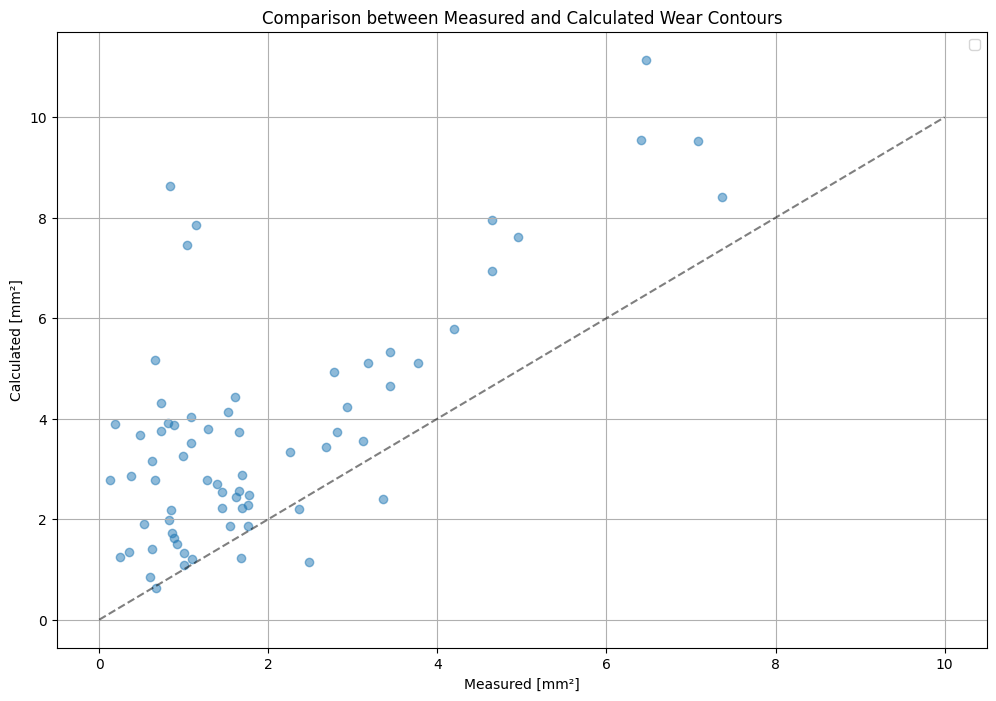

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours")
ax.scatter(np.array(measured_wear_area) * 1e6, np.array(calculated_wear_area) * 1e6, color='C0', alpha=0.5)
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_overall.pdf", bbox_inches='tight', dpi=300)